In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from time import time
import warnings
warnings.filterwarnings('ignore')

In [32]:
trainSetValuePath='./datasets/Taarifa Waterpoints/Taarifa_Waterpoints_Values.csv'
trainSetLabelPath='./datasets/Taarifa Waterpoints/Taarifa_Waterpoints_Labels.csv'

print(trainSetValuePath+' dataset values not found!') if not os.path.isfile(trainSetValuePath) else print(trainSetValuePath+' dataset values found!')
print(trainSetLabelPath+' dataset labels not found!') if not os.path.isfile(trainSetLabelPath) else print(trainSetLabelPath+' dataset labels found!')

trainData = pd.read_csv(trainSetValuePath)
trainLabel = pd.read_csv(trainSetLabelPath)
trainData = trainData.merge(trainLabel, on="id")

./datasets/Taarifa_Waterpoints_Values.csv dataset values been found!
./datasets/Taarifa_Waterpoints_Labels.csv dataset labels been found!


In [33]:
trainData.head(7)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional


In [34]:
trainData.shape

(59400, 41)

In [35]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [36]:
trainData = trainData.drop(['id','date_recorded','wpt_name','region','recorded_by'], axis=1)

In [37]:
numericFeatures = ['amount_tsh','gps_height','longitude','latitude','num_private',
                   'region_code','district_code','population','construction_year']

for column in numericFeatures:
    upperThreshold=np.percentile(trainData[column],95)
    lowerThreshold=np.percentile(trainData[column],5)
    normalDataIndices=np.where((trainData[column]<upperThreshold)&(trainData[column]>lowerThreshold))
    normalDataIndices=np.array(normalDataIndices).flatten()
    normalData = trainData[column][normalDataIndices]
    meanValue=np.mean(normalData)
    print('The column:',column,"'s upper threshold is:",upperThreshold,', lower threshold is:',lowerThreshold,', mean value is:',meanValue)
    trainData[column]=trainData[column].fillna(meanValue)

The column: amount_tsh 's upper threshold is: 1200.0 , lower threshold is: 0.0 , mean value is: 276.8419775235258
The column: gps_height 's upper threshold is: 1797.0 , lower threshold is: 0.0 , mean value is: 979.5605160168141
The column: longitude 's upper threshold is: 39.13323954 , lower threshold is: 30.040660006499998 , mean value is: 35.023721943734195
The column: latitude 's upper threshold is: -1.4088722265000002 , lower threshold is: -10.5855499165 , mean value is: -5.706804948837076
The column: num_private 's upper threshold is: 0.0 , lower threshold is: 0.0 , mean value is: nan
The column: region_code 's upper threshold is: 60.0 , lower threshold is: 2.0 , mean value is: 12.16969864747291
The column: district_code 's upper threshold is: 30.0 , lower threshold is: 1.0 , mean value is: 4.078932905885047
The column: population 's upper threshold is: 680.0 , lower threshold is: 0.0 , mean value is: 174.2756494433343
The column: construction_year 's upper threshold is: 2010.0 , 

In [38]:
def printNullColumn():
    incompleteColumn=[]
    missingValuesCount = trainData.isnull().sum()
    for key,value in missingValuesCount.items():
        if value!=0:
            incompleteColumn.append(key)
            print(f"The column {key}, has: {value} numbers of null value.")
    if len(incompleteColumn)==0:
        print('All columns have a value now.')
    return incompleteColumn

incompleteColumn=printNullColumn()

The column funder, has: 3635 numbers of null value.
The column installer, has: 3655 numbers of null value.
The column subvillage, has: 371 numbers of null value.
The column public_meeting, has: 3334 numbers of null value.
The column scheme_management, has: 3877 numbers of null value.
The column scheme_name, has: 28166 numbers of null value.
The column permit, has: 3056 numbers of null value.


In [39]:
for column in incompleteColumn:
    mostFrequentObject=trainData[column].value_counts().idxmax()
    trainData[column].fillna(mostFrequentObject,inplace=True)
incompleteColumn=printNullColumn()

All columns have a value now.


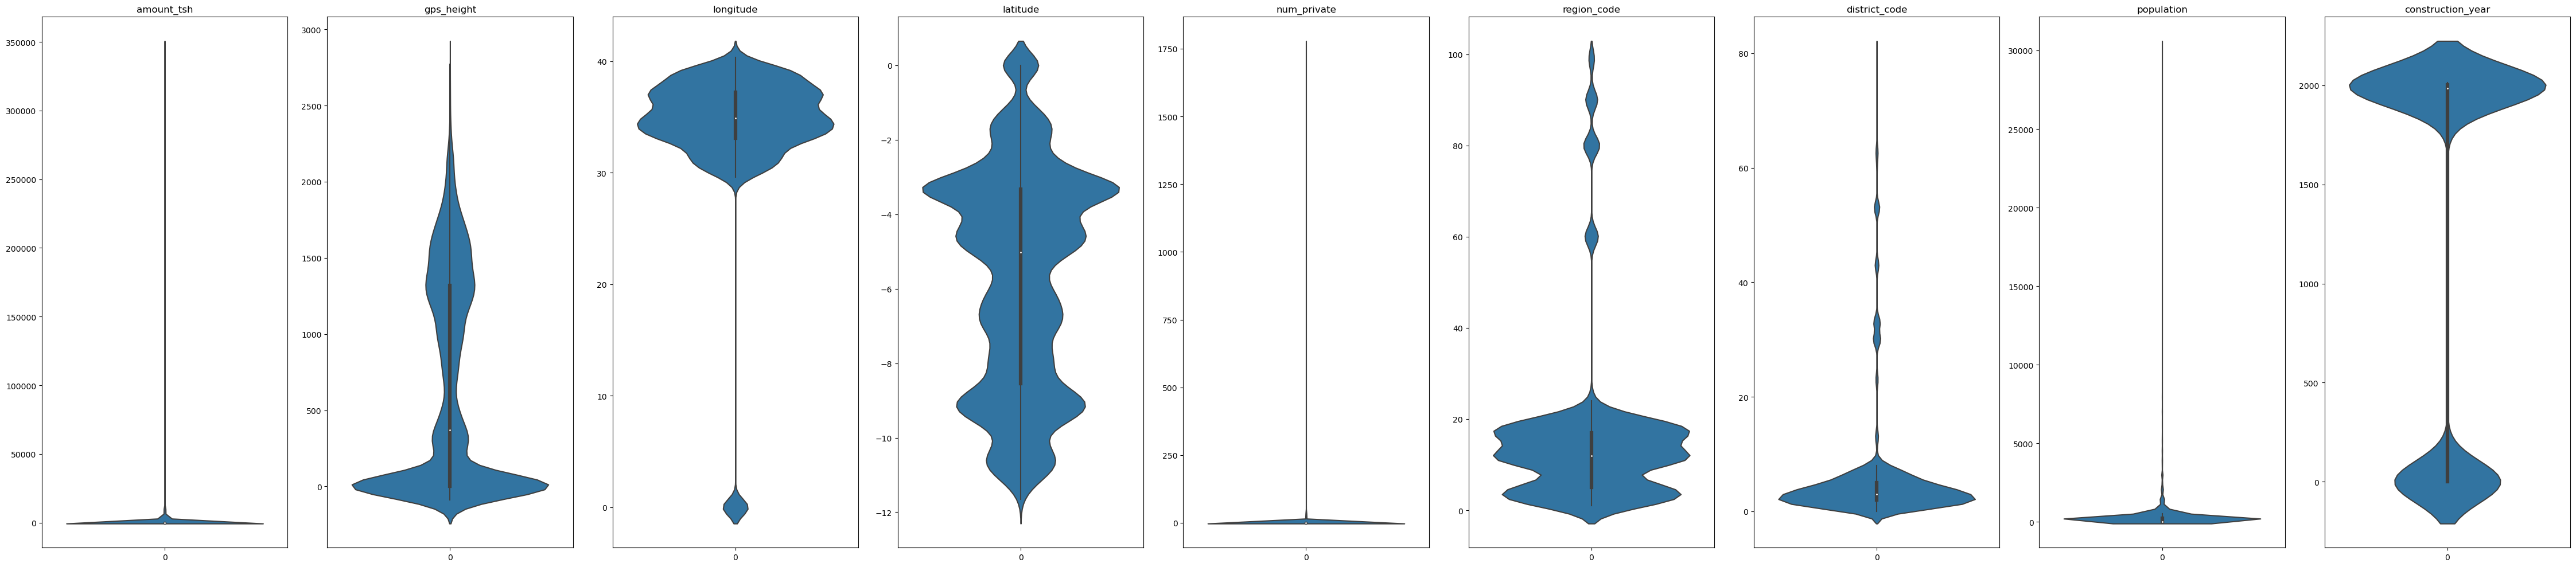

In [40]:
numberOfPlots = len(numericFeatures)
fig,axes=plt.subplots(1,numberOfPlots, figsize=(numberOfPlots*5,10))
for i,feature in enumerate(numericFeatures):
    sns.violinplot(data=trainData[feature], ax=axes[i])
    axes[i].set_title(feature)
plt.tight_layout()
plt.show()

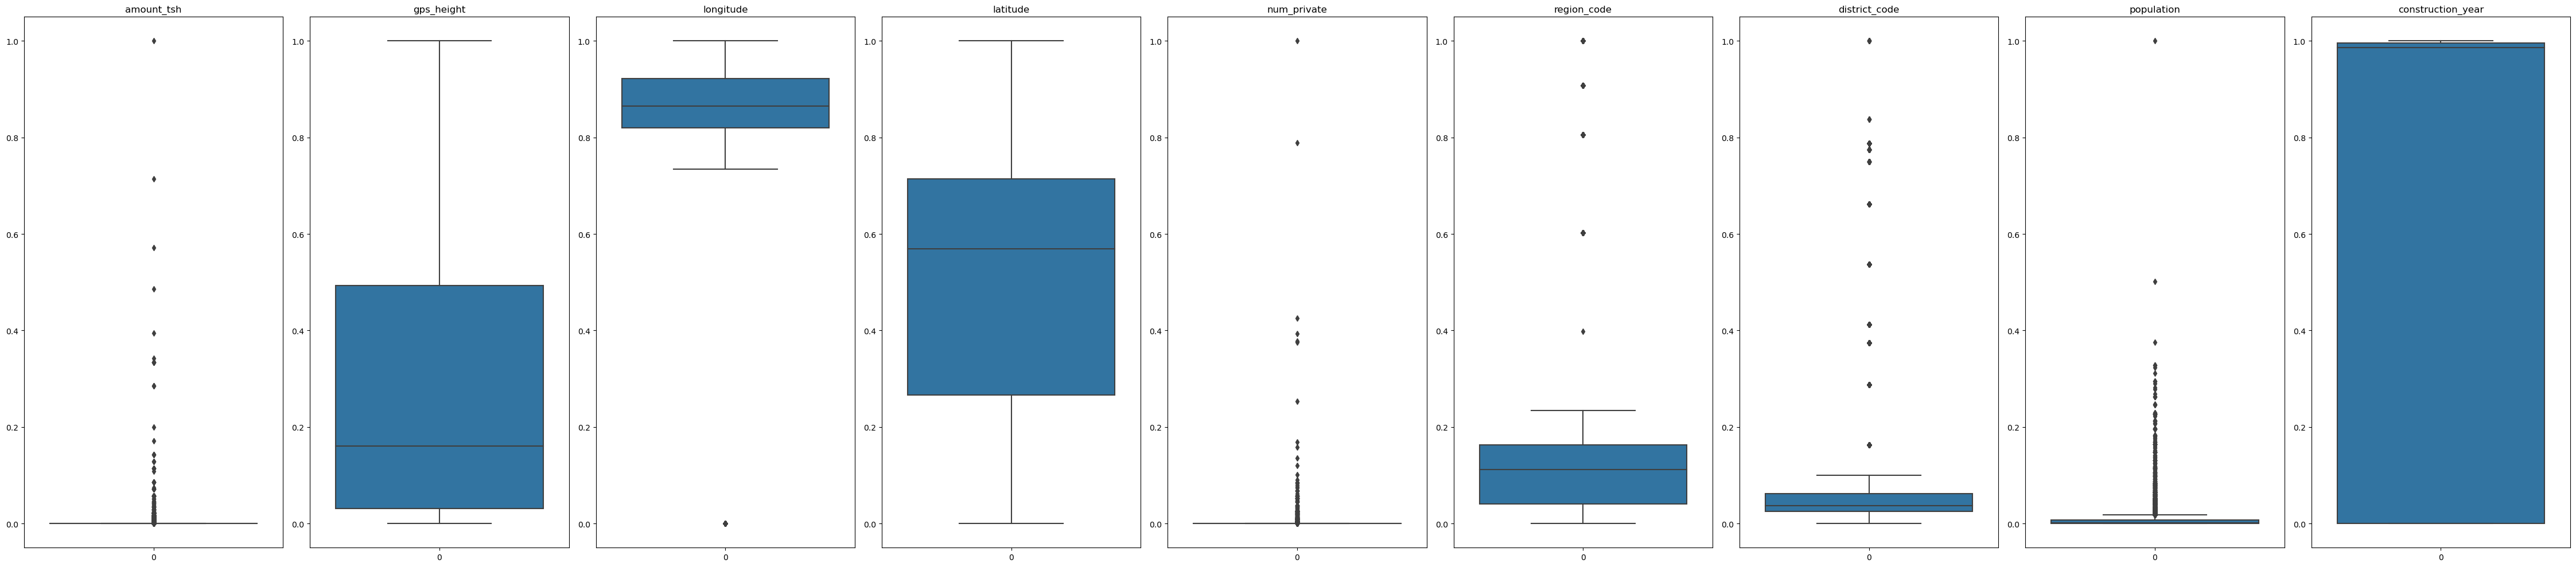

In [41]:
minMaxScaler = MinMaxScaler()
trainData[numericFeatures]=minMaxScaler.fit_transform(trainData[numericFeatures])

fig,axes=plt.subplots(1,numberOfPlots, figsize=(numberOfPlots*5,10))
for i,feature in enumerate(numericFeatures):
    sns.boxplot(data=trainData[feature], ax=axes[i])
    axes[i].set_title(feature)
plt.tight_layout()
plt.show()

In [42]:
categoricalFeatures=[]
for columnName,columnData in trainData.items():
    if type(trainData[columnName][0])==str:
        categoricalFeatures.append(columnName)
print('These columns has string data, thus they should be transformed by OneHot:')
print(categoricalFeatures,end='')

These columns has string data, thus they should be transformed by OneHot:
['funder', 'installer', 'basin', 'subvillage', 'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']

In [43]:
categoricalFeatures.remove('status_group')
for column in categoricalFeatures:
    trainData[column] = LabelEncoder().fit_transform(trainData[column])
trainData[categoricalFeatures]=minMaxScaler.fit_transform(trainData[categoricalFeatures])
mapping={'functional':1,'non functional':2,'functional needs repair':3}
trainData['status_group']=trainData['status_group'].map(mapping)
cleanedData=trainData
trainData.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0.017143,0.722046,0.517483,0.708022,0.865979,0.153923,0.0,0.125,0.612206,0.102041,...,0.857143,0.4,0.25,0.25,0.888889,1.000000,0.0,0.166667,0.2,1
1,0.000000,0.247363,0.520629,0.254198,0.860047,0.815659,0.0,0.500,0.821217,0.193878,...,0.857143,0.4,0.50,0.50,0.555556,0.500000,0.5,0.166667,0.2,1
2,0.000071,0.435127,0.271329,0.955224,0.928504,0.671973,0.0,0.625,0.470497,0.204082,...,0.857143,0.4,0.25,0.25,0.000000,0.166667,0.5,0.333333,0.2,1
3,0.000000,0.918249,0.123427,0.863806,0.953922,0.042418,0.0,0.875,0.465726,0.908163,...,0.857143,0.4,0.00,0.00,0.333333,0.000000,0.0,0.333333,0.2,2
4,0.000000,0.010549,0.031469,0.055504,0.771612,0.843309,0.0,0.500,0.399150,0.173469,...,0.857143,0.4,0.75,0.75,0.555556,0.500000,0.5,0.166667,0.2,1


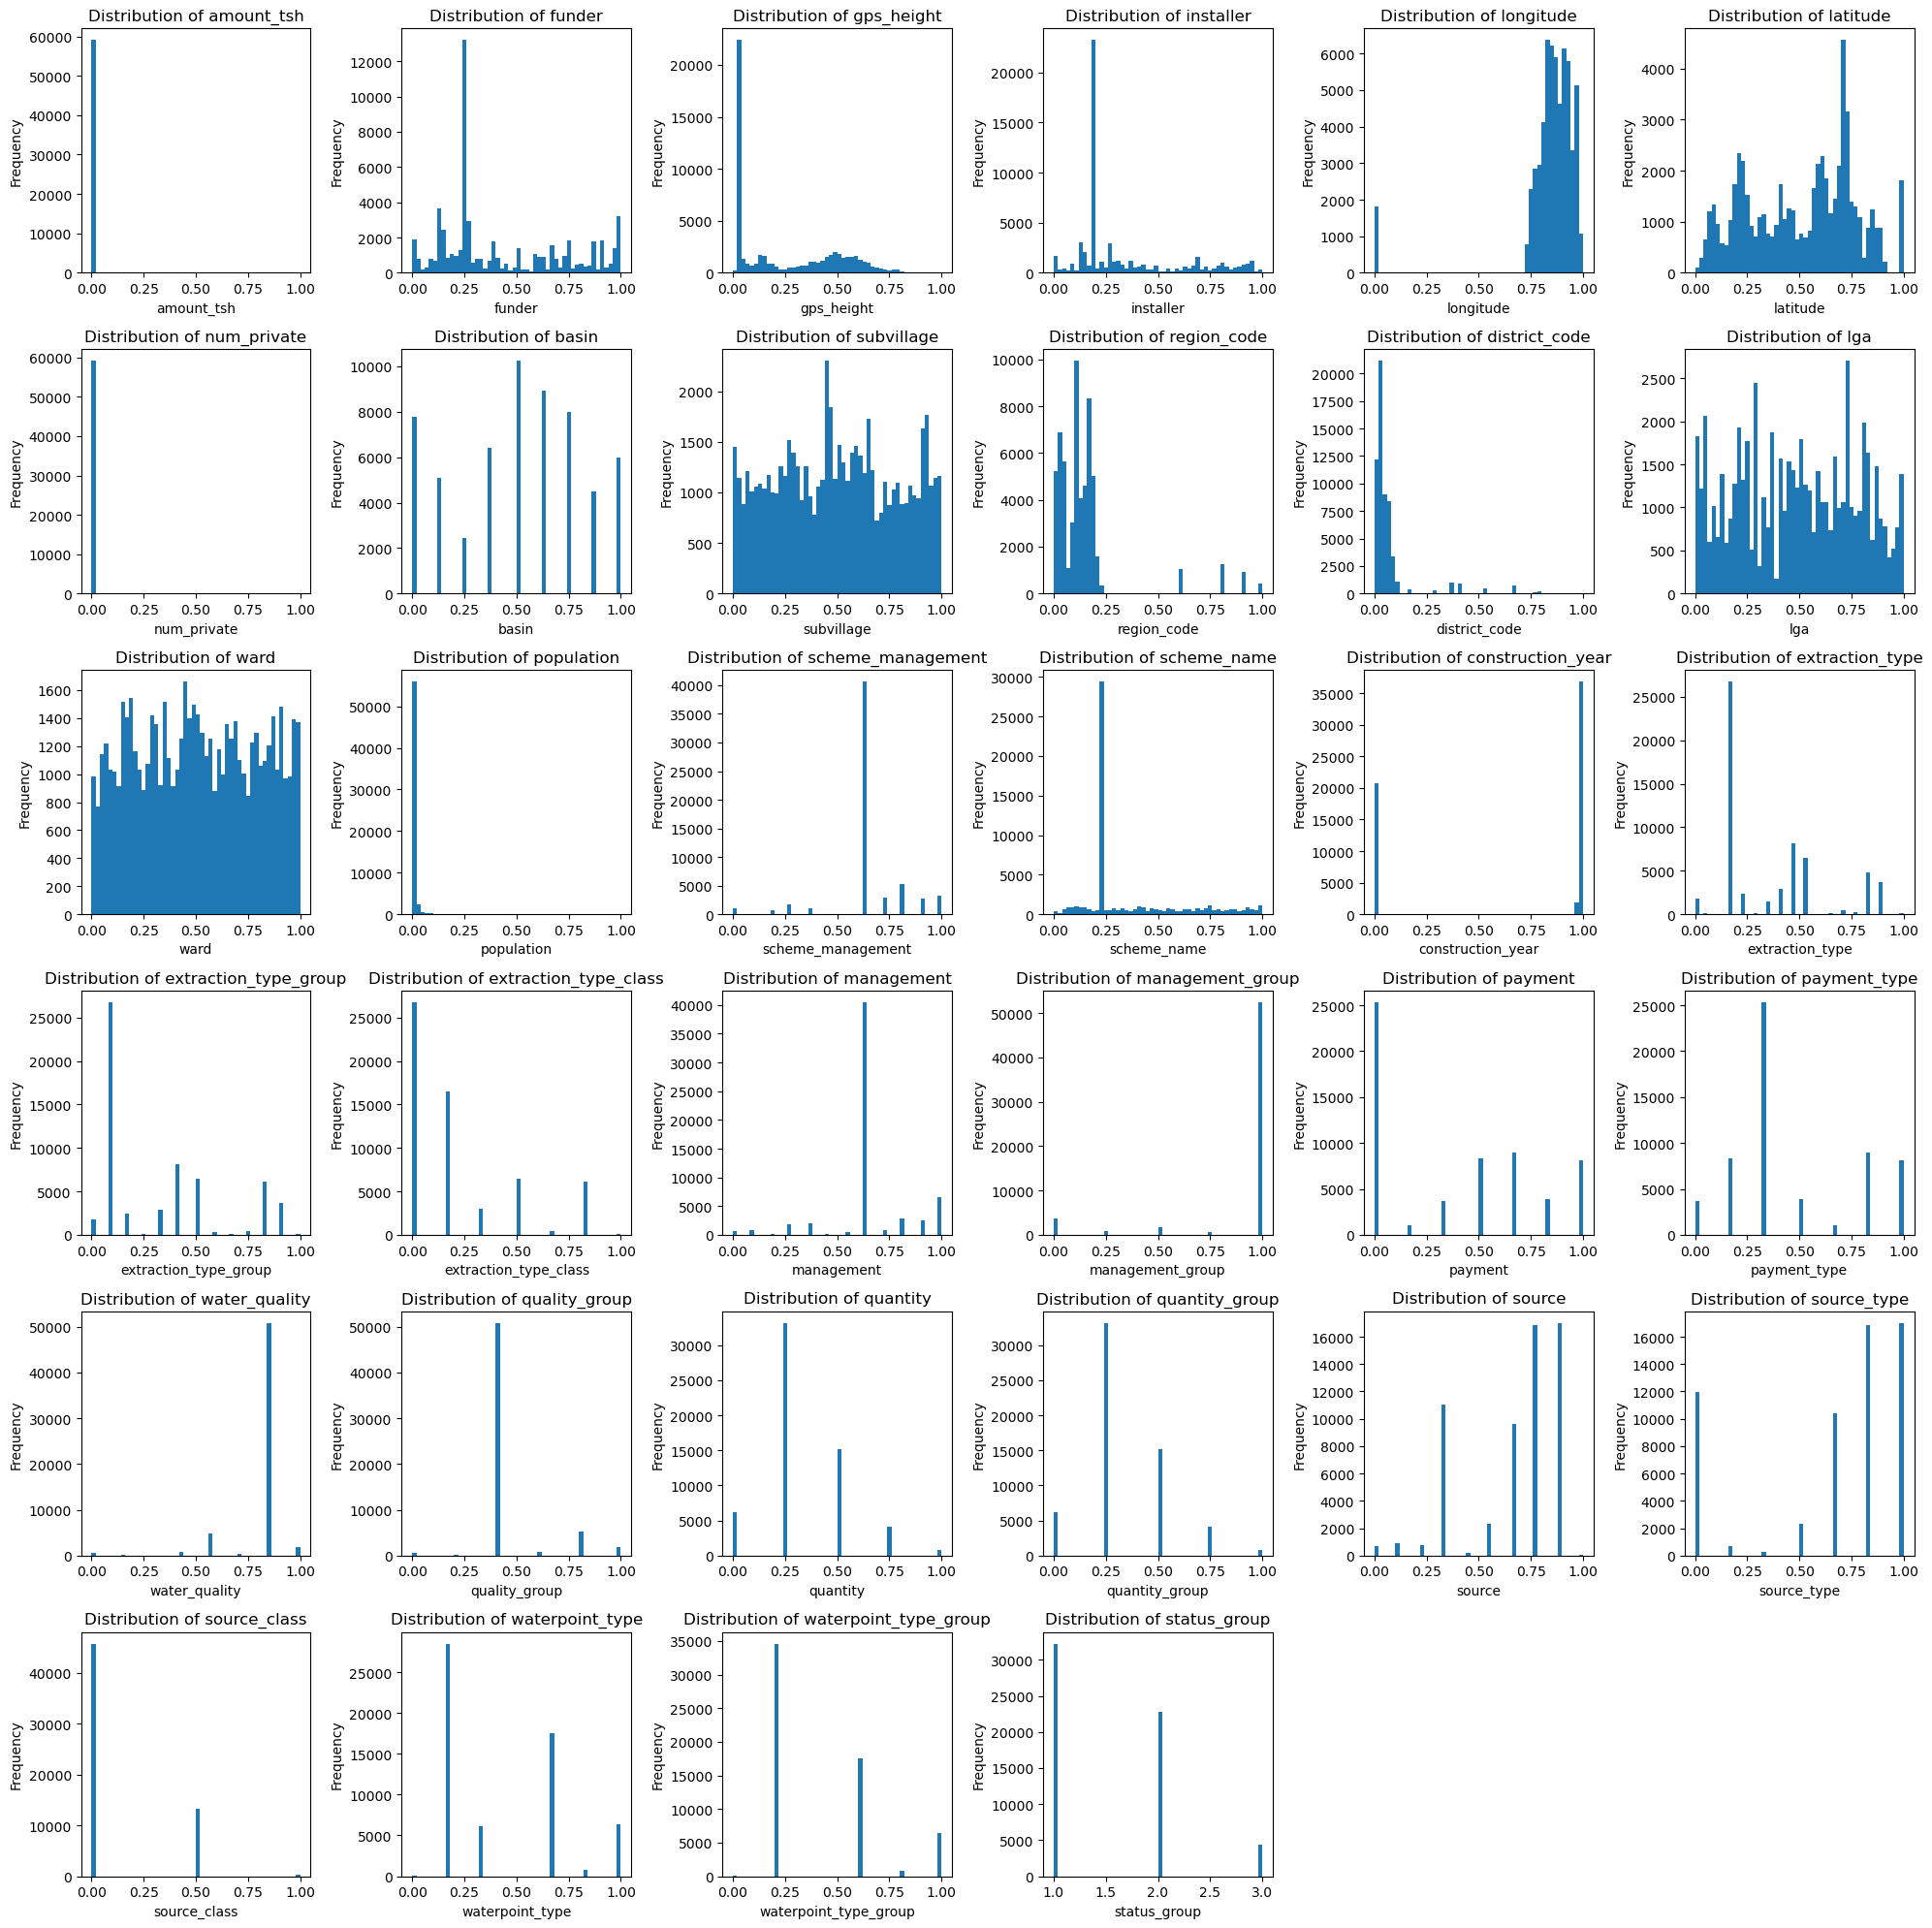

In [44]:
numeric_features = cleanedData.select_dtypes(include=[np.number])
num_features = len(cleanedData.columns)
fig, axes = plt.subplots(6, 6, figsize=(20,20))
for i, feature in enumerate(numeric_features.columns):
    row = i // 6
    col = i % 6
    axes[row, col].hist(trainData[feature], bins=50)
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
for i in range(34,36):
    axes.flatten()[i].axis('off')
plt.tight_layout()
plt.show()

In [45]:
X = trainData.drop("status_group", axis=1)
Y = trainData["status_group"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

def MLP_fit(X_train,X_test,Y_train,Y_test,hidden_ls=(3,),max_i=1000):
    MLP=MLPClassifier(hidden_layer_sizes=hidden_ls,
                      activation='logistic',
                      max_iter=max_i,
                      random_state=42)
    MLP.fit(X_train,Y_train)
    yTrainPred = MLP.predict(X_train)
    Train_acc=accuracy_score(Y_train,yTrainPred)*100
    print("The training accuracy is: {:.3f}%".format(Train_acc))
    MLP.fit(X_test, Y_test)
    yTestPred = MLP.predict(X_test)
    Test_acc=accuracy_score(Y_test,yTestPred)*100
    print("The testing accuracy is: {:.3f}%".format(Test_acc))

print('A defult model without tuned was done,')
MLP_fit(X_train,X_test,Y_train,Y_test)

A defult model without tuned was done,
The training accuracy is: 69.919%
The testing accuracy is: 69.785%


In [46]:
def reSampleDataset(df1Number,df2Number,df3Number,ratio):
      print('The functional group have sample amount of:{},\nThe non functional group have sample amount of:{},\nThe functional need repair group have sample amount of:{}' 
            .format(len(trainData[trainData['status_group']==1]),
                  len(trainData[trainData['status_group']==2]),
                  len(trainData[trainData['status_group']==3])))

      trimmedDF1=trainData[trainData['status_group']==1].sample(n=df1Number, random_state=42)
      trimmedDF2=trainData[trainData['status_group']==2].sample(n=df2Number, random_state=42)
      originalDF3=trainData[trainData['status_group']==3]
      upScaleRatio=ratio
      upScaledDF3=originalDF3.sample(n=int(len(trainData[trainData['status_group']==3])*upScaleRatio),replace=True,random_state=42)
      trimmedDF3=upScaledDF3.sample(n=df3Number, random_state=42)
      reSampledTrainData=pd.concat([trimmedDF1,trimmedDF2,trimmedDF3],axis=0)
      reSampledTrainData=reSampledTrainData.sample(frac=1,random_state=42).reset_index(drop=True)
      reSampledTrainData.to_csv('./datasets/Taarifa Waterpoints/Taarifa_Waterpoints_Cleaned_Dataste.csv')
      print('After down sampling and upscaling, the sample number of dataset is:{}'.format(len(reSampledTrainData)))
      
      feature = reSampledTrainData.drop("status_group", axis=1)
      label = reSampledTrainData["status_group"]
      return feature,label

In [47]:
X,Y=reSampleDataset(30000,20000,10000,3)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

startTime=time()
print('After balencing the dataset,')
MLP_fit(X_train,X_test,Y_train,Y_test)
print('Train finished takes:',time()-startTime)

The functional group have sample amount of:32259,
The non functional group have sample amount of:22824,
The functional need repair group have sample amount of:4317
After down sampling and upscaling, the sample number of dataset is:60000
After balencing the dataset,
The training accuracy is: 63.987%
The testing accuracy is: 63.600%
Train finished takes: 6.837791919708252


In [48]:
X,Y=reSampleDataset(30000,20000,1000,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

startTime=time()
print('After balencing the dataset again,')
MLP_fit(X_train,X_test,Y_train,Y_test)
print('Train finished takes:',time()-startTime)

The functional group have sample amount of:32259,
The non functional group have sample amount of:22824,
The functional need repair group have sample amount of:4317
After down sampling and upscaling, the sample number of dataset is:51000
After balencing the dataset again,
The training accuracy is: 74.928%
The testing accuracy is: 74.463%
Train finished takes: 8.070274353027344


In [49]:
def CrossV(Model,CV_num=4):
    print(' CV of the Model is: '.center(100,'*'))
    CV=cross_val_score(Model,X,Y,cv=CV_num,scoring='accuracy')
    print(CV,', Average score is: {:.3f}%'.format(CV.mean()*100))

def ConfusionM(yTest,yTestPred):
    CM=pd.DataFrame(data=[accuracy_score(yTest,yTestPred)*100, 
                    recall_score(yTest,yTestPred,average='weighted',zero_division=1)*100, 
                    precision_score(yTest,yTestPred,average='weighted',zero_division=1)*100,
                    f1_score(yTest,yTestPred,average='weighted',zero_division=1)*100],
                    index=['Accuracy','Recall','Precision','F1-score'],
                    columns=['Score'])
    print(' Confusion matrix of the model is: '.center(100,'*'))                
    print(CM)

In [50]:
MLP=MLPClassifier(hidden_layer_sizes=(3,),
                  activation='logistic',
                  max_iter=1000,
                  random_state=42)
MLP.fit(X_train,Y_train)
Y_test_pred = MLP.predict(X_test)
CrossV(MLP,CV_num=5)
ConfusionM(Y_test,Y_test_pred)

*************************************** CV of the Model is: ****************************************
[0.75117647 0.74568627 0.75313725 0.74735294 0.74882353] , Average score is: 74.924%
******************************** Confusion matrix of the model is: *********************************
               Score
Accuracy   75.521569
Recall     75.521569
Precision  77.332513
F1-score   73.522576


In [51]:
neurons=[5,6,7,8,9,10]
iters=[500,1000,5000]
activatioin=['identity','logistic','tanh','relu']
optimalNeurons=None
optimalIteration=None
optimalActivation=None

def findHyperParameter():
    trainAccuracy=[]
    trainPrecision=[]
    trainRecall=[]
    neuronList=[]
    iterList=[]
    actList=[]
    optimalScore=0
    for n in neurons:
        for i in range(len(iters)):
            for a in activatioin:
                MLP=MLPClassifier(hidden_layer_sizes=(n,), activation=a, max_iter=iters[i], random_state=42)
                MLP.fit(X_train, Y_train)
                Y_test_pred=MLP.predict(X_test)
                score=accuracy_score(Y_test, Y_test_pred)
                trainAccuracy.append(score)
                trainPrecision.append(precision_score(Y_test, Y_test_pred, average='weighted',zero_division=1))
                trainRecall.append(recall_score(Y_test, Y_test_pred, average='weighted',zero_division=1))
                neuronList.append(n)
                iterList.append(iters[i])
                actList.append(a)
                if score > optimalScore:
                    optimalScore=score
                    optimalNeurons=n
                    optimalIteration=iters[i]
                    optimalActivation=a
    trainRecord = {'Neurons':neuronList,
                   'iters':iterList,
                   'activation':actList,
                   'trainAccuracy':trainAccuracy,
                   'trainPrecision':trainPrecision,
                   'trainRecall':trainRecall}
    trainRecord = pd.DataFrame(trainRecord)
    print('The best hyperparameter is: {} neurons, {} iterations, {} actication'.format(optimalNeurons,optimalIteration,optimalActivation))
    return trainRecord

The best hyperparameter is: 10 neurons, 500 iterations, tanh actication


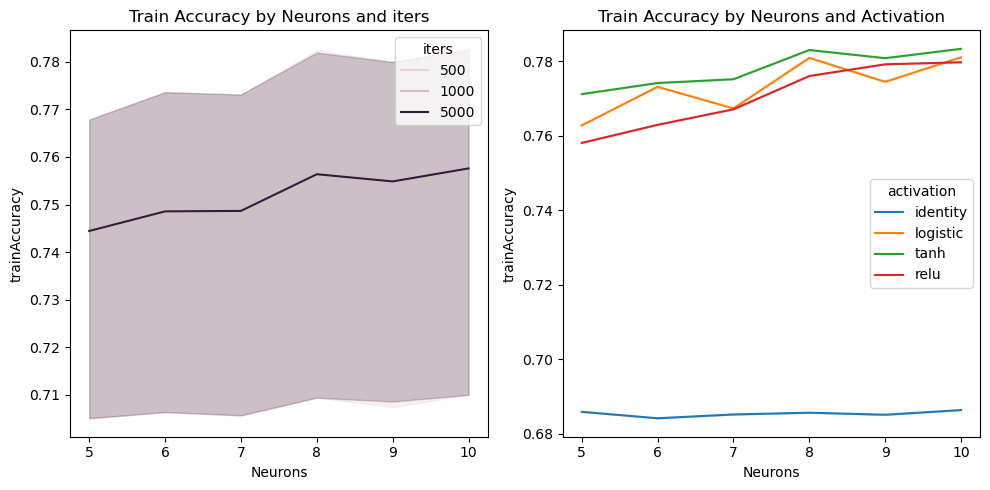

In [52]:
record=findHyperParameter()
recordColumn=['Neurons','iters','activation','trainAccuracy','trainPrecision','trainRecall']
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=record, x='Neurons', y='trainAccuracy', hue='iters', ax=axes[0])
axes[0].set_title('Train Accuracy by Neurons and iters')
sns.lineplot(data=record, x='Neurons', y='trainAccuracy', hue='activation', ax=axes[1])
axes[1].set_title('Train Accuracy by Neurons and Activation')
plt.tight_layout()
plt.show()

In [53]:
MLP=MLPClassifier(hidden_layer_sizes=(10,),activation='tanh',max_iter=500).fit(X_train,Y_train)
Train_acc=MLP.score(X_train,Y_train)*100
print("The MLP final training score is : {:.3f}%".format(Train_acc))
Test_acc=MLP.score(X_test,Y_test)*100
print("The MLP final testing score is: {:.3f}%".format(Test_acc))

The MLP final training score is : 77.595%
The MLP final testing score is: 78.227%


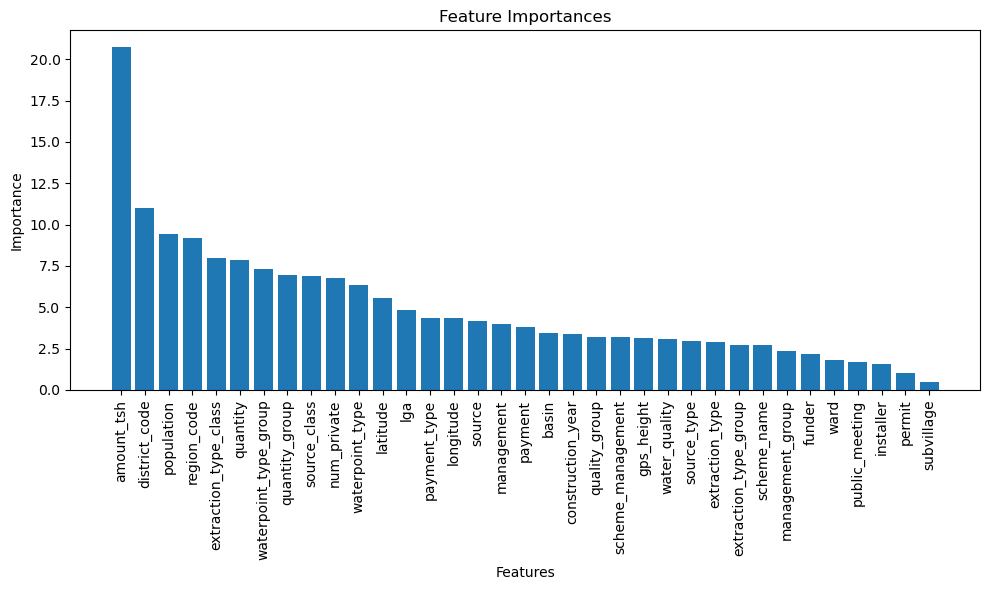

In [54]:
neuroWeights=np.abs(MLP.coefs_[0])
featureImportance=np.sum(neuroWeights, axis=1)
featureImportance=pd.DataFrame({'Feature': X.columns, 'Importance': featureImportance})
featureImportance=featureImportance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(featureImportance['Feature'], featureImportance['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [55]:
print('The top 10 features which impact the pump status most are:')
importantFeature=featureImportance[:10]['Feature']
featureImportance[:10]

The top 10 features which impact the pump status most are:


,Feature,Importance
0,amount_tsh,20.721977
10,district_code,10.982451
13,population,9.405037
9,region_code,9.196385
21,extraction_type_class,7.949449
28,quantity,7.853393
34,waterpoint_type_group,7.313125
29,quantity_group,6.921067
32,source_class,6.893991
6,num_private,6.783835


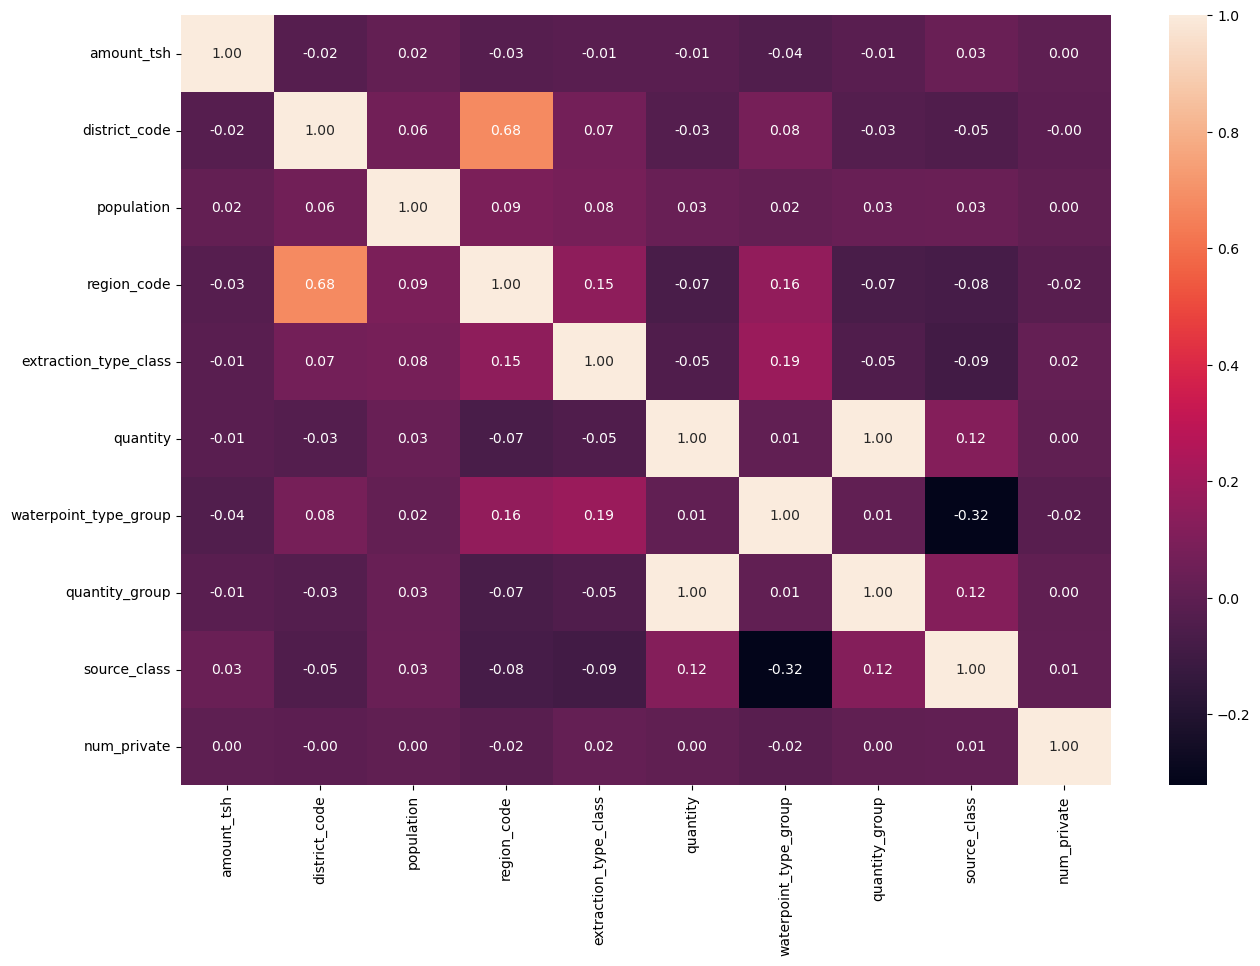

In [56]:
correlations = cleanedData[importantFeature].corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlations, annot=True, fmt=".2f")
plt.show()